In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rl_glue import RLGlue

from environment import BaseEnvironment
from car_racing import CarRacingEnvironment
from agent import BaseAgent 

from collections import deque
from copy import deepcopy
from tqdm import tqdm
import os 
import shutil
from plot_script import plot_result


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

## Neural Network for action values

We use a neural network with one hidden layer for approximating the action-value function in a control problem. The output layer size is the number of actions. 

The get_action_values() function computes the action-value function by doing a forward pass.
The get_TD_update() function computes the gradient of the action-value function with respect to the weights times the TD error.

In [2]:
class ActionValueNetwork:

    def __init__(self, network_config):
        self.state_dim = network_config.get("state_dim")
        self.num_actions = network_config.get("num_actions")
        self.learning_rate = network_config.get("learning_rate")

#         inputs = layers.Input(shape=(self.state_dim, self.state_dim, 3))
#         # Convolutions on the frames on the screen
#         layer1 = layers.Conv2D(6, 7, strides=4, activation="relu")(inputs)
#         layer2 = layers.MaxPooling2D(pool_size = (2,2))(layer1)
#         layer3 = layers.Conv2D(12, 4, strides=2, activation="relu")(layer2)
#         layer4 = layers.MaxPooling2D(pool_size = (2,2))(layer3)
#         layer5 = layers.Flatten()(layer4)
#         layer6 = layers.Dense(512, activation="relu")(layer5)
#         action = layers.Dense(self.num_actions, activation="linear")(layer6)

#         self.model =  keras.Model(inputs=inputs, outputs=action)
        
        model = Sequential()
#         model.add(layers.Input(shape=(self.state_dim, self.state_dim, 3)))
        model.add(layers.Conv2D(filters = 6, kernel_size = 7, strides=3, activation="relu", input_shape = (self.state_dim, self.state_dim, 3)))
        
        model.add(layers.MaxPooling2D(pool_size = (2,2)))
        model.add(layers.Conv2D(filters = 12, kernel_size = 4, activation="relu"))
        model.add(layers.MaxPooling2D(pool_size = (2,2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(216, activation="relu"))
        model.add(layers.Dense(self.num_actions, activation=None))
        model.compile(loss = 'mean_squared_error', optimizer=Adam(lr=self.learning_rate, epsilon=1e-7))
        self.model = model
#         model = models.Sequential()
#         model.add(layers.Conv2D(32, 8, strides = 4, activation='relu', input_shape=(32, 32, 3)))
#         model.add(layers.MaxPooling2D((2, 2)))
#         model.add(layers.Conv2D(64, 4, strides = 2, activation='relu'))
#         model.add(layers.MaxPooling2D((2, 2)))
#         model.add(layers.Conv2D(64, 3, activation='relu'))
#         model.add(layers.Flatten())
#         model.add(layers.Dense(512, activation="relu")(layer4))
#         model.add(layers.Dense(self.num_actions, activation="linear"))
        
#         self.model = model

    def get_action_values(self, s):
        """
        Args:
            s (Numpy array): The state.
        Returns:
            The action-values (Numpy array) calculated using the network's weights.
        """
        
        q_vals = self.model.predict(s)

        return q_vals
    

#     def get_TD_update(self, s, delta_mat):
#         """
#         Args:
#             s (Numpy array): The state.
#             delta_mat (Numpy array): A 2D array of shape (batch_size, num_actions). Each row of delta_mat  
#             correspond to one state in the batch. Each row has only one non-zero element 
#             which is the TD-error corresponding to the action taken.
#         Returns:
#             The TD update (Array of dictionaries with gradient times TD errors) for the network's weights
#         """

#         W0, b0 = self.weights[0]['W'], self.weights[0]['b']
#         W1, b1 = self.weights[1]['W'], self.weights[1]['b']
        
#         psi = np.dot(s, W0) + b0
#         x = np.maximum(psi, 0)
#         dx = (psi > 0).astype(float)

#         # td_update has the same structure as self.weights, that is an array of dictionaries.
#         # td_update[0]["W"], td_update[0]["b"], td_update[1]["W"], and td_update[1]["b"] have the same shape as 
#         # self.weights[0]["W"], self.weights[0]["b"], self.weights[1]["W"], and self.weights[1]["b"] respectively
#         td_update = [dict() for i in range(len(self.weights))]
         
#         v = delta_mat
#         td_update[1]['W'] = np.dot(x.T, v) * 1. / s.shape[0]
#         td_update[1]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]
        
#         v = np.dot(v, W1.T) * dx
#         td_update[0]['W'] = np.dot(s.T, v) * 1. / s.shape[0]
#         td_update[0]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]
                
#         return td_update
        
    
    def get_weights(self):
        return self.model.get_weights()
    
    def set_weights(self, weights):
        self.model.set_weights(weights)
        

## Replay Buffer

In [3]:
class ReplayBuffer:
    def __init__(self, size, minibatch_size, seed):
        """
        Args:
            size (integer): The size of the replay buffer.              
            minibatch_size (integer): The sample size.
            seed (integer): The seed for the random number generator. 
        """
        self.buffer = []
        self.minibatch_size = minibatch_size
        self.rand_generator = np.random.RandomState(seed)
        self.max_size = size

    def append(self, state, action, reward, terminal, next_state):
        """
        Args:
            state (Numpy array): The state.              
            action (integer): The action.
            reward (float): The reward.
            terminal (integer): 1 if the next state is a terminal state and 0 otherwise.
            next_state (Numpy array): The next state.           
        """
        if len(self.buffer) == self.max_size:
            del self.buffer[0]
        state = state.astype('float32')
        next_state = next_state.astype('float32')
        self.buffer.append([state, action, reward, terminal, next_state])

    def sample(self):
        """
        Returns:
            A list of transition tuples including state, action, reward, terinal, and next_state
        """
        idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]

    def size(self):
        return len(self.buffer)

## Softmax

In [4]:
def softmax(action_values, tau=1.0):
    """
    Args:
        action_values (Numpy array): A 2D array of shape (batch_size, num_actions). 
                       The action-values computed by an action-value network.              
        tau (float): The temperature parameter scalar.
    Returns:
        A 2D array of shape (batch_size, num_actions). Where each column is a probability distribution over
        the actions representing the policy.
    """
    
    # Compute the preferences by dividing the action-values by the temperature parameter tau
    preferences = action_values/tau
    # Compute the maximum preference across the actions
    max_preference = np.max(preferences, axis=1)
        
    
    # Reshape max_preference array which has shape [Batch,] to [Batch, 1]. This allows NumPy broadcasting 
    # when subtracting the maximum preference from the preference of each action.
    reshaped_max_preference = max_preference.reshape((-1, 1))
    
    # Compute the numerator, i.e., the exponential of the preference - the max preference.
    exp_preferences = np.exp(preferences - reshaped_max_preference)
    # Compute the denominator, i.e., the sum over the numerator along the actions axis.
    sum_of_exp_preferences = np.sum(exp_preferences, axis=1)
    
   
    
    # Reshape sum_of_exp_preferences array which has shape [Batch,] to [Batch, 1] to  allow for NumPy broadcasting 
    # when dividing the numerator by the denominator.
    reshaped_sum_of_exp_preferences = sum_of_exp_preferences.reshape((-1, 1))
    
    # Compute the action probabilities according to the equation in the previous cell.
    action_probs = exp_preferences/reshaped_sum_of_exp_preferences
    
   
    
    
    # squeeze() removes any singleton dimensions. It is used here because this function is used in the 
    # agent policy when selecting an action (for which the batch dimension is 1.) As np.random.choice is used in 
    # the agent policy and it expects 1D arrays, we need to remove this singleton batch dimension.
    action_probs = action_probs.squeeze()
    return action_probs

## Compiling



In [5]:
def get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau):
    """
    Args:
        states (Numpy array): The batch of states with the shape (batch_size, state_dim).
        next_states (Numpy array): The batch of next states with the shape (batch_size, state_dim).
        actions (Numpy array): The batch of actions with the shape (batch_size,).
        rewards (Numpy array): The batch of rewards with the shape (batch_size,).
        discount (float): The discount factor.
        terminals (Numpy array): The batch of terminals with the shape (batch_size,).
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    Returns:
        The TD errors (Numpy array) for actions taken, of shape (batch_size,)
    """
    
    # Here network is the latest state of the network that is getting replay updates. In other words, 
    # the network represents Q_{t+1}^{i} whereas current_q represents Q_t, the fixed network used for computing the 
    # targets, and particularly, the action-values at the next-states.
    
    # Compute action values at next states using current_q network
    # q_next_mat is a 2D array of shape (batch_size, num_actions)
    
    # Q(t+1)
    q_next_mat = current_q.get_action_values(next_states)
 
    # Compute policy at next state by passing the action-values in q_next_mat to softmax()
    # probs_mat is a 2D array of shape (batch_size, num_actions)
    
    # Pi
    probs_mat = softmax(q_next_mat, tau)

    # Compute the estimate of the next state value, v_next_vec.
    # v_next_vec is a 1D array of shape (batch_size,)

    v_next_vec = np.sum(probs_mat * q_next_mat, axis=1) * (1-terminals)
    
    # Compute Expected Sarsa target
    # target_vec is a 1D array of shape (batch_size,)
    
    # 
    target_vec = rewards + discount*v_next_vec

    # Compute action values at the current states for all actions using network
    # q_mat is a 2D array of shape (batch_size, num_actions)
   
    q_mat = network.get_action_values(states)

    # Batch Indices is an array from 0 to the batch size - 1. 
    batch_indices = np.arange(q_mat.shape[0])

    # Compute q_vec by selecting q(s, a) from q_mat for taken actions
    # Use batch_indices as the index for the first dimension of q_mat
    # q_vec is a 1D array of shape (batch_size)
    
#     q_vec = q_mat[batch_indices, int(actions)]

    # Compute TD errors for actions taken
    # delta_vec is a 1D array of shape (batch_size)
    
#     delta_vec = target_vec - q_vec
    target = np.zeros(q_next_mat.shape)
    for i in range(q_next_mat.shape[0]):
        
        target[i,int(actions[i])] = target_vec[i]
        
    return target

In [6]:
def optimize_network(experiences, discount, optimizer, network, current_q, tau):
    """
    Args:
        experiences (Numpy array): The batch of experiences including the states, actions, 
                                   rewards, terminals, and next_states.
        discount (float): The discount factor.
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    """
    
    # Get states, action, rewards, terminals, and next_states from experiences
    states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
    states = np.concatenate(states)
    next_states = np.concatenate(next_states)
    rewards = np.array(rewards)
    terminals = np.array(terminals)
    batch_size = states.shape[0]
    loss_function = keras.losses.Huber()
    # Compute TD error using the get_td_error function
    # q_vec is a 1D array of shape (batch_size)
    target_vec = get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau)
    
    network.model.fit(states, target_vec, epochs=1, verbose=0)

    

## Agent


In [7]:
class Agent(BaseAgent):
    def __init__(self):
        self.name = "expected_sarsa_agent"
        
    def agent_init(self, agent_config):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the agent.

        Assume agent_config dict contains:
        {
            network_config: dictionary,
            optimizer_config: dictionary,
            replay_buffer_size: integer,
            minibatch_sz: integer, 
            num_replay_updates_per_step: float
            discount_factor: float,
        }
        """
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'], 
                                          agent_config['minibatch_sz'], agent_config.get("seed"))
        self.network = ActionValueNetwork(agent_config['network_config'])
        self.network_target = ActionValueNetwork(agent_config['network_config'])
        self.num_actions = agent_config['network_config']['num_actions']
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']
        
        self.rand_generator = np.random.RandomState(agent_config.get("seed"))
        self.epsilon = 0.01
        self.last_state = None
        self.last_action = None
        self.sum_rewards = 0
        self.episode_steps = 0
        self.optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
        self.action_space = np.array([i for i in range(self.num_actions)])
        self.action_space = self.action_space.astype('float32')
        self.eps = 1
        self.eps_min = 0.1
        self.eps_decay = 0.999

    def policy(self, state):
        """
        Args:
            state (Numpy array): the state.
        Returns:
            the action. 
        """
        if np.random.rand() > self.epsilon:
            
            action_values = self.network.get_action_values(state)
            probs_batch = softmax(action_values, self.tau)
            action = self.rand_generator.choice(self.num_actions, p=probs_batch.squeeze())
        else:
            action = np.random.choice(self.action_space)
        return action

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = np.array([state])
        self.last_action = self.policy(self.last_state)
        return self.last_action


    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        
        self.sum_rewards += reward
        self.episode_steps += 1
        
        # Make state an array of shape (1, state_dim) to add a batch dimension and
        # to later match the get_action_values() and get_TD_update() functions
        state = np.array([state])

        # Select action
        action = self.policy(state)
        
        # Append new experience to replay buffer
        self.replay_buffer.append(self.last_state, self.last_action, reward, 0, state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
#             current_q = deepcopy(self.network)
            self.network_target.set_weights(self.network.get_weights())
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network 
                optimize_network(experiences, self.discount, self.optimizer, self.network, self.network_target, self.tau)
                
        # Update the last state and last action.
        self.last_state = state
        self.last_action = action
        
        if self.eps > self.eps_min:
            self.eps *= self.eps_decay
        
        
        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.sum_rewards += reward
        self.episode_steps += 1
        
        # Set terminal state to an array of zeros
        state = np.zeros_like(self.last_state)

        # Append new experience to replay buffer       
       
        self.replay_buffer.append(self.last_state, self.last_action, reward, 1, state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
#             current_q = deepcopy(self.network)
            self.network_target.set_weights(self.network.get_weights())
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network
                optimize_network(experiences, self.discount, self.optimizer, self.network, self.network_target, self.tau)
                
        
    def trained_agent_step(self, reward, state):
        """A step taken by the trained agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        
        
        self.sum_rewards += reward
        # Make state an array of shape (1, state_dim) to add a batch dimension and
        # to later match the get_action_values() and get_TD_update() functions
        state = np.array([state])

        # Select action
        action = self.policy(state)
        
        return action
    
    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")

In [8]:
def save_weights_to_json(model, file_name, path):
    model_json = model.to_json()
    file_name1 = ( str(file_name)+".json")
    path = os.path.join(path, file_name1)
    with open(path , "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model_json = model.to_json()
    file_name2 = ( str(file_name)+".h5")
    path = os.path.join(path, file_name2)
    model.save_weights(path)
    print("Saved model to disk")
    
def loaf_weights_from_json(model, file_name, path):
    file_name1 = ( str(file_name)+".json")
    path = os.path.join(path, file_name1)
    json_file = open(path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    file_name2 = ( str(file_name)+".h5")
    path = os.path.join(path, file_name2)
    loaded_model.load_weights(path)
    print("Loaded model from disk")

## Run the experiment

In [9]:

def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):
    
    rl_glue = RLGlue(environment, agent)
        
    # save sum of reward at the end of each episode
    agent_sum_reward = np.zeros((experiment_parameters["num_runs"], 
                                 experiment_parameters["num_episodes"]))
    trained_agent_sum_reward = np.zeros((experiment_parameters["num_runs"], 
                                 experiment_parameters["num_episodes_trained"]))

    env_info = {}

    agent_info = agent_parameters

    # one agent setting
    for run in range(1, experiment_parameters["num_runs"]+1):
        agent_info["seed"] = run
        agent_info["network_config"]["seed"] = run
        env_info["seed"] = run

        rl_glue.rl_init(agent_info, env_info)

            
        for episode in tqdm(range(1, experiment_parameters["num_episodes"]+1)):
            # run episode
            rl_glue.rl_episode(experiment_parameters["timeout"])
            
            episode_reward = rl_glue.rl_agent_message("get_sum_reward")
            agent_sum_reward[run - 1, episode - 1] = episode_reward
            
        
        for episode in range(1, experiment_parameters["num_episodes_trained"]+1):
            rl_glue.trained_rl_episode(experiment_parameters["timeout"])
            trained_agent_sum_reward[run - 1, episode - 1 ] =  rl_glue.rl_env_message("get_sum_reward")
            
            print("Trained reward = " + str(trained_agent_sum_reward))
    save_name = "{}".format(rl_glue.agent.name)
    if not os.path.exists('results'):
        os.makedirs('results')
    np.save("results/sum_reward_{}".format(save_name), agent_sum_reward)
    shutil.make_archive('results', 'zip', 'results')
    
    
# Run Experiment
# tf.debugging.set_log_device_placement(True)
# Experiment parameters
experiment_parameters = {
    "num_runs" : 1,
    "num_episodes_trained" : 1,
    "num_episodes" : 100,
    # OpenAI Gym environments allow for a timestep limit timeout, causing episodes to end after 
    # some number of timesteps. Here we use the default of 500.
    "timeout" : 500
}

# Environment parameters
environment_parameters = {}

current_env = CarRacingEnvironment

# Agent parameters
agent_parameters = {
    'network_config': {
        'state_dim': 96,
        'num_actions': 5,
        'learning_rate':0.001
    },
    'replay_buffer_size': 5000,
    'minibatch_sz': 8,
    'num_replay_updates_per_step': 4,
    'gamma': 0.99,
    'tau': 0.001
}
current_agent = Agent

# run experiment
run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

C:\Users\Kirat\Anaconda3\envs\TensorGPU, Keras\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Track generation: 1143..1442 -> 299-tiles track


C:\Users\Kirat\Anaconda3\envs\TensorGPU, Keras\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
  1%|▊                                                                             | 1/100 [06:45<11:09:38, 405.84s/it]

Track generation: 1087..1369 -> 282-tiles track


  2%|█▌                                                                            | 2/100 [13:32<11:04:00, 406.53s/it]

Track generation: 964..1212 -> 248-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1176..1474 -> 298-tiles track


  3%|██▎                                                                           | 3/100 [20:21<10:58:33, 407.35s/it]

Track generation: 1283..1608 -> 325-tiles track


  4%|███                                                                           | 4/100 [27:11<10:53:26, 408.40s/it]

Track generation: 1217..1526 -> 309-tiles track


  5%|███▉                                                                          | 5/100 [34:00<10:46:52, 408.56s/it]

Track generation: 1096..1374 -> 278-tiles track


  6%|████▋                                                                         | 6/100 [40:50<10:40:50, 409.05s/it]

Track generation: 1198..1501 -> 303-tiles track


  7%|█████▍                                                                        | 7/100 [47:39<10:34:28, 409.34s/it]

Track generation: 1159..1453 -> 294-tiles track


  8%|██████▏                                                                       | 8/100 [54:30<10:28:26, 409.86s/it]

Track generation: 957..1205 -> 248-tiles track


  9%|██████▊                                                                     | 9/100 [1:01:22<10:22:11, 410.24s/it]

Track generation: 1181..1480 -> 299-tiles track


 10%|███████▌                                                                   | 10/100 [1:08:14<10:16:19, 410.88s/it]

Track generation: 979..1234 -> 255-tiles track


 11%|████████▎                                                                  | 11/100 [1:15:06<10:10:13, 411.38s/it]

Track generation: 1320..1654 -> 334-tiles track


 12%|█████████                                                                  | 12/100 [1:22:02<10:05:17, 412.69s/it]

Track generation: 1067..1338 -> 271-tiles track


 13%|█████████▊                                                                 | 13/100 [1:28:59<10:00:19, 414.02s/it]

Track generation: 1067..1338 -> 271-tiles track


 14%|██████████▋                                                                 | 14/100 [1:36:00<9:56:28, 416.15s/it]

Track generation: 1207..1513 -> 306-tiles track


 15%|███████████▍                                                                | 15/100 [1:42:58<9:50:20, 416.71s/it]

Track generation: 1106..1396 -> 290-tiles track


 16%|████████████▏                                                               | 16/100 [1:48:40<9:11:56, 394.24s/it]

Track generation: 1296..1628 -> 332-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1047..1319 -> 272-tiles track


 17%|████████████▉                                                               | 17/100 [1:51:20<7:27:56, 323.81s/it]

Track generation: 1245..1560 -> 315-tiles track


 18%|█████████████▋                                                              | 18/100 [1:58:15<7:59:55, 351.16s/it]

Track generation: 1232..1544 -> 312-tiles track


 19%|██████████████▍                                                             | 19/100 [2:05:09<8:19:33, 370.04s/it]

Track generation: 1120..1408 -> 288-tiles track


 20%|███████████████▏                                                            | 20/100 [2:12:04<8:31:08, 383.36s/it]

Track generation: 1225..1536 -> 311-tiles track


 21%|███████████████▉                                                            | 21/100 [2:18:57<8:36:49, 392.53s/it]

Track generation: 1077..1357 -> 280-tiles track


 22%|████████████████▋                                                           | 22/100 [2:21:25<6:54:53, 319.14s/it]

Track generation: 1322..1664 -> 342-tiles track


 23%|█████████████████▍                                                          | 23/100 [2:28:20<7:26:20, 347.80s/it]

Track generation: 1035..1297 -> 262-tiles track


 24%|██████████████████▏                                                         | 24/100 [2:33:12<6:59:24, 331.11s/it]

Track generation: 1297..1626 -> 329-tiles track


 25%|███████████████████                                                         | 25/100 [2:40:06<7:25:01, 356.02s/it]

Track generation: 1294..1621 -> 327-tiles track


 26%|███████████████████▊                                                        | 26/100 [2:47:00<7:40:20, 373.25s/it]

Track generation: 1055..1331 -> 276-tiles track


 27%|████████████████████▌                                                       | 27/100 [2:49:38<6:15:40, 308.78s/it]

Track generation: 1202..1507 -> 305-tiles track


 28%|█████████████████████▎                                                      | 28/100 [2:56:32<6:48:14, 340.20s/it]

Track generation: 863..1087 -> 224-tiles track


 29%|██████████████████████                                                      | 29/100 [2:58:56<5:33:03, 281.46s/it]

Track generation: 1227..1538 -> 311-tiles track


 30%|██████████████████████▊                                                     | 30/100 [3:05:50<6:14:48, 321.27s/it]

Track generation: 1317..1652 -> 335-tiles track


 31%|███████████████████████▌                                                    | 31/100 [3:12:44<6:41:23, 349.04s/it]

Track generation: 1115..1402 -> 287-tiles track


 32%|████████████████████████▎                                                   | 32/100 [3:15:00<5:22:56, 284.95s/it]

Track generation: 1168..1464 -> 296-tiles track


 33%|█████████████████████████                                                   | 33/100 [3:21:54<6:01:25, 323.67s/it]

Track generation: 1056..1324 -> 268-tiles track


 34%|█████████████████████████▊                                                  | 34/100 [3:28:48<6:26:08, 351.04s/it]

Track generation: 1204..1509 -> 305-tiles track


 35%|██████████████████████████▌                                                 | 35/100 [3:35:42<6:40:43, 369.90s/it]

Track generation: 1260..1579 -> 319-tiles track


 36%|███████████████████████████▎                                                | 36/100 [3:42:37<6:48:46, 383.23s/it]

Track generation: 1100..1379 -> 279-tiles track


 37%|████████████████████████████                                                | 37/100 [3:49:31<6:52:16, 392.64s/it]

Track generation: 1185..1485 -> 300-tiles track


 38%|████████████████████████████▉                                               | 38/100 [3:56:25<6:52:16, 398.97s/it]

Track generation: 1034..1296 -> 262-tiles track


 39%|█████████████████████████████▋                                              | 39/100 [4:03:19<6:50:15, 403.53s/it]

Track generation: 1076..1352 -> 276-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1132..1419 -> 287-tiles track


 40%|██████████████████████████████▍                                             | 40/100 [4:10:13<6:46:42, 406.72s/it]

Track generation: 1292..1619 -> 327-tiles track


 41%|███████████████████████████████▏                                            | 41/100 [4:17:07<6:42:04, 408.89s/it]

Track generation: 1275..1598 -> 323-tiles track


 42%|███████████████████████████████▉                                            | 42/100 [4:24:01<6:36:46, 410.45s/it]

Track generation: 1056..1324 -> 268-tiles track


 43%|████████████████████████████████▋                                           | 43/100 [4:30:55<6:30:51, 411.42s/it]

Track generation: 1092..1377 -> 285-tiles track


 44%|█████████████████████████████████▍                                          | 44/100 [4:37:48<6:24:32, 412.00s/it]

Track generation: 1127..1413 -> 286-tiles track


 45%|██████████████████████████████████▏                                         | 45/100 [4:44:42<6:18:03, 412.43s/it]

Track generation: 1104..1384 -> 280-tiles track


 46%|██████████████████████████████████▉                                         | 46/100 [4:51:36<6:11:31, 412.80s/it]

Track generation: 1131..1430 -> 299-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1195..1498 -> 303-tiles track


 47%|███████████████████████████████████▋                                        | 47/100 [4:58:30<6:05:02, 413.25s/it]

Track generation: 1155..1448 -> 293-tiles track


 48%|████████████████████████████████████▍                                       | 48/100 [5:05:24<5:58:26, 413.58s/it]

Track generation: 1317..1650 -> 333-tiles track


 49%|█████████████████████████████████████▏                                      | 49/100 [5:12:18<5:51:43, 413.79s/it]

Track generation: 1180..1479 -> 299-tiles track


 50%|██████████████████████████████████████                                      | 50/100 [5:19:12<5:44:50, 413.81s/it]

Track generation: 1170..1467 -> 297-tiles track


 51%|██████████████████████████████████████▊                                     | 51/100 [5:26:07<5:38:10, 414.09s/it]

Track generation: 1022..1282 -> 260-tiles track


 52%|███████████████████████████████████████▌                                    | 52/100 [5:33:11<5:33:36, 417.02s/it]

Track generation: 1230..1542 -> 312-tiles track


 53%|████████████████████████████████████████▎                                   | 53/100 [5:40:05<5:25:55, 416.07s/it]

Track generation: 1018..1278 -> 260-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1126..1412 -> 286-tiles track


 54%|█████████████████████████████████████████                                   | 54/100 [5:46:59<5:18:34, 415.52s/it]

Track generation: 1251..1568 -> 317-tiles track


 55%|█████████████████████████████████████████▊                                  | 55/100 [5:53:53<5:11:20, 415.11s/it]

Track generation: 1202..1507 -> 305-tiles track


 56%|██████████████████████████████████████████▌                                 | 56/100 [6:00:47<5:04:13, 414.86s/it]

Track generation: 1265..1592 -> 327-tiles track


 57%|███████████████████████████████████████████▎                                | 57/100 [6:07:42<4:57:12, 414.70s/it]

Track generation: 1049..1315 -> 266-tiles track


 58%|████████████████████████████████████████████                                | 58/100 [6:14:36<4:50:07, 414.47s/it]

Track generation: 1345..1685 -> 340-tiles track


 59%|████████████████████████████████████████████▊                               | 59/100 [6:21:30<4:43:13, 414.47s/it]

Track generation: 929..1167 -> 238-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1059..1328 -> 269-tiles track


 60%|█████████████████████████████████████████████▌                              | 60/100 [6:28:24<4:36:09, 414.24s/it]

Track generation: 981..1236 -> 255-tiles track


 61%|██████████████████████████████████████████████▎                             | 61/100 [6:31:05<3:39:48, 338.17s/it]

Track generation: 1220..1529 -> 309-tiles track


 62%|███████████████████████████████████████████████                             | 62/100 [6:37:58<3:48:31, 360.83s/it]

Track generation: 1062..1332 -> 270-tiles track


 63%|███████████████████████████████████████████████▉                            | 63/100 [6:44:51<3:52:08, 376.44s/it]

Track generation: 1148..1439 -> 291-tiles track


 64%|████████████████████████████████████████████████▋                           | 64/100 [6:51:45<3:52:34, 387.63s/it]

Track generation: 983..1235 -> 252-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1106..1387 -> 281-tiles track


 65%|█████████████████████████████████████████████████▍                          | 65/100 [6:58:38<3:50:34, 395.28s/it]

Track generation: 1068..1339 -> 271-tiles track


 66%|██████████████████████████████████████████████████▏                         | 66/100 [7:05:31<3:46:59, 400.58s/it]

Track generation: 1285..1611 -> 326-tiles track


 67%|██████████████████████████████████████████████████▉                         | 67/100 [7:12:25<3:42:31, 404.58s/it]

Track generation: 1224..1534 -> 310-tiles track


 68%|███████████████████████████████████████████████████▋                        | 68/100 [7:19:18<3:37:06, 407.08s/it]

Track generation: 1095..1373 -> 278-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1209..1515 -> 306-tiles track


 69%|████████████████████████████████████████████████████▍                       | 69/100 [7:26:12<3:31:21, 409.10s/it]

Track generation: 1167..1463 -> 296-tiles track


 70%|█████████████████████████████████████████████████████▏                      | 70/100 [7:33:05<3:25:12, 410.42s/it]

Track generation: 1215..1523 -> 308-tiles track


 71%|█████████████████████████████████████████████████████▉                      | 71/100 [7:39:59<3:18:50, 411.39s/it]

Track generation: 1292..1619 -> 327-tiles track


 72%|██████████████████████████████████████████████████████▋                     | 72/100 [7:43:52<2:47:06, 358.11s/it]

Track generation: 1099..1378 -> 279-tiles track


 73%|███████████████████████████████████████████████████████▍                    | 73/100 [7:50:46<2:48:38, 374.77s/it]

Track generation: 1179..1478 -> 299-tiles track


 74%|████████████████████████████████████████████████████████▏                   | 74/100 [7:57:39<2:47:21, 386.22s/it]

Track generation: 1107..1388 -> 281-tiles track


 75%|█████████████████████████████████████████████████████████                   | 75/100 [8:04:33<2:44:25, 394.62s/it]

Track generation: 1209..1519 -> 310-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1233..1544 -> 311-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1234..1555 -> 321-tiles track


 76%|█████████████████████████████████████████████████████████▊                  | 76/100 [8:11:27<2:40:10, 400.42s/it]

Track generation: 1232..1553 -> 321-tiles track


 77%|██████████████████████████████████████████████████████████▌                 | 77/100 [8:19:05<2:40:02, 417.50s/it]

Track generation: 1214..1522 -> 308-tiles track


 78%|███████████████████████████████████████████████████████████▎                | 78/100 [8:26:57<2:39:09, 434.08s/it]

Track generation: 1151..1450 -> 299-tiles track


 79%|████████████████████████████████████████████████████████████                | 79/100 [8:30:05<2:06:04, 360.24s/it]

Track generation: 1213..1529 -> 316-tiles track


 80%|████████████████████████████████████████████████████████████▊               | 80/100 [8:33:09<1:42:27, 307.36s/it]

Track generation: 1252..1569 -> 317-tiles track


 81%|█████████████████████████████████████████████████████████████▌              | 81/100 [8:40:37<1:50:41, 349.54s/it]

Track generation: 1040..1304 -> 264-tiles track


 82%|██████████████████████████████████████████████████████████████▎             | 82/100 [8:45:28<1:39:34, 331.91s/it]

Track generation: 1128..1414 -> 286-tiles track


 83%|███████████████████████████████████████████████████████████████             | 83/100 [8:52:44<1:42:55, 363.25s/it]

Track generation: 1121..1408 -> 287-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1048..1319 -> 271-tiles track


 84%|███████████████████████████████████████████████████████████████▊            | 84/100 [8:55:41<1:21:53, 307.11s/it]

Track generation: 1224..1534 -> 310-tiles track


 85%|████████████████████████████████████████████████████████████████▌           | 85/100 [9:03:55<1:30:50, 363.39s/it]

Track generation: 1140..1429 -> 289-tiles track


 86%|█████████████████████████████████████████████████████████████████▎          | 86/100 [9:12:14<1:34:16, 404.03s/it]

Track generation: 1114..1400 -> 286-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1052..1319 -> 267-tiles track


 87%|██████████████████████████████████████████████████████████████████          | 87/100 [9:20:56<1:35:13, 439.50s/it]

Track generation: 1045..1313 -> 268-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1131..1418 -> 287-tiles track


 88%|██████████████████████████████████████████████████████████████████▉         | 88/100 [9:29:41<1:32:58, 464.90s/it]

Track generation: 1122..1412 -> 290-tiles track


 89%|███████████████████████████████████████████████████████████████████▋        | 89/100 [9:32:36<1:09:18, 378.08s/it]

Track generation: 1239..1553 -> 314-tiles track


 90%|████████████████████████████████████████████████████████████████████▍       | 90/100 [9:41:01<1:09:21, 416.11s/it]

Track generation: 1022..1283 -> 261-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1123..1408 -> 285-tiles track


 91%|█████████████████████████████████████████████████████████████████████▏      | 91/100 [9:49:23<1:06:17, 441.97s/it]

Track generation: 1158..1462 -> 304-tiles track


 92%|███████████████████████████████████████████████████████████████████████▊      | 92/100 [9:52:10<47:54, 359.34s/it]

Track generation: 1313..1645 -> 332-tiles track


 93%|████████████████████████████████████████████████████████████████████████▌     | 93/100 [9:59:16<44:16, 379.57s/it]

Track generation: 1000..1254 -> 254-tiles track


 94%|████████████████████████████████████████████████████████████████████████▍    | 94/100 [10:06:35<39:42, 397.14s/it]

Track generation: 1259..1578 -> 319-tiles track


 95%|█████████████████████████████████████████████████████████████████████████▏   | 95/100 [10:13:36<33:42, 404.52s/it]

Track generation: 1316..1655 -> 339-tiles track


 96%|█████████████████████████████████████████████████████████████████████████▉   | 96/100 [10:16:09<21:55, 328.91s/it]

Track generation: 1086..1367 -> 281-tiles track


 97%|██████████████████████████████████████████████████████████████████████████▋  | 97/100 [10:18:29<13:36, 272.29s/it]

Track generation: 988..1238 -> 250-tiles track


 98%|███████████████████████████████████████████████████████████████████████████▍ | 98/100 [10:25:23<10:29, 314.78s/it]

Track generation: 1072..1344 -> 272-tiles track


 99%|████████████████████████████████████████████████████████████████████████████▏| 99/100 [10:32:17<05:44, 344.71s/it]

Track generation: 1152..1444 -> 292-tiles track


100%|████████████████████████████████████████████████████████████████████████████| 100/100 [10:39:11<00:00, 383.52s/it]


Track generation: 1066..1341 -> 275-tiles track
Trained reward = [[nan]]


FileNotFoundError: [Errno 2] No such file or directory: './/sum_reward_random_agent.npy'

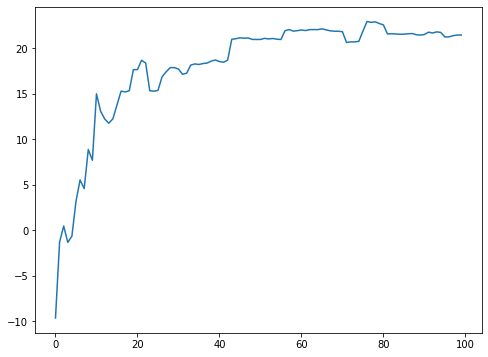

In [10]:
plot_result(["expected_sarsa_agent", "random_agent"])